# MNIST classifier
Goal is to classify mnist dataset with 97% accuracy on test set.

Hint: Use `KNeighboursClassifier` and try different hyperparameters to acchive goal.

### Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display

### Load mnist dataset

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)

### Explore data

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

(70000, 784)

(70000,)

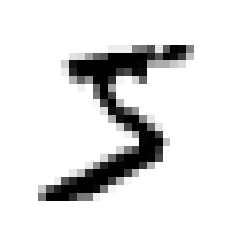

In [3]:
display(mnist.keys())

X, Y = mnist['data'], mnist['target']

display(X.shape, Y.shape)

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

### Split data into train and test data

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10000, random_state=42)

### Train model using k-nearest neighbour classifier and do predictions on test data

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, Y_train)

Y_pred = knn_clf.predict(X_test)

### Get classification report and accuracy of predictions

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

result1 = classification_report(Y_test, Y_pred)
print(result1)

accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       983
           1       0.95      1.00      0.97      1152
           2       0.98      0.96      0.97       967
           3       0.96      0.97      0.96      1034
           4       0.98      0.96      0.97       906
           5       0.97      0.96      0.97       937
           6       0.98      0.98      0.98       961
           7       0.96      0.97      0.97      1055
           8       0.99      0.92      0.95       969
           9       0.96      0.96      0.96      1036

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

0.9696


### Do model selection by doing randomized search on knn classifier hyperparameters

In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_neighbors': [2, 3, 4], 'weights': ['uniform', 'distance']}

knn_clf = KNeighborsClassifier(n_jobs=1)

random_search = RandomizedSearchCV(knn_clf, param_dist,
    n_iter=5, cv=2, scoring='accuracy', return_train_score=True, random_state=42, n_jobs=8)
random_search.fit(X_train, Y_train)

display(random_search.best_score_)
display(random_search.best_params_)

0.9679833333333334

{'weights': 'distance', 'n_neighbors': 4}

### Select a final model, do predictions on test data and print classification report and accuracy

In [11]:
final_model = random_search.best_estimator_

Y_pred_final = final_model.predict(X_test)

report = classification_report(Y_test, Y_pred_final)
print(report)

accuracy = accuracy_score(Y_test, Y_pred_final)
print(accuracy)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       983
           1       0.96      1.00      0.98      1152
           2       0.98      0.97      0.98       967
           3       0.97      0.97      0.97      1034
           4       0.98      0.96      0.97       906
           5       0.97      0.97      0.97       937
           6       0.98      0.99      0.98       961
           7       0.96      0.97      0.97      1055
           8       0.99      0.94      0.96       969
           9       0.96      0.96      0.96      1036

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

0.9729


### Analyzing errors that classifier makes

In [13]:
from sklearn.model_selection import cross_val_predict

Y_train_pred = cross_val_predict(final_model, X_train, Y_train, cv=3, n_jobs=-1)

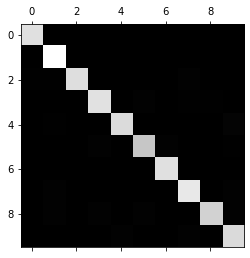

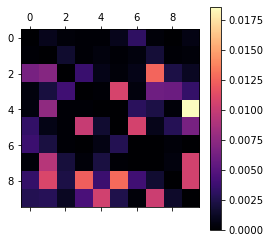

In [29]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(Y_train, Y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)

# show normalized errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap='magma')
plt.colorbar()
plt.show()

### Improving classification by generating more test samples by rotating them

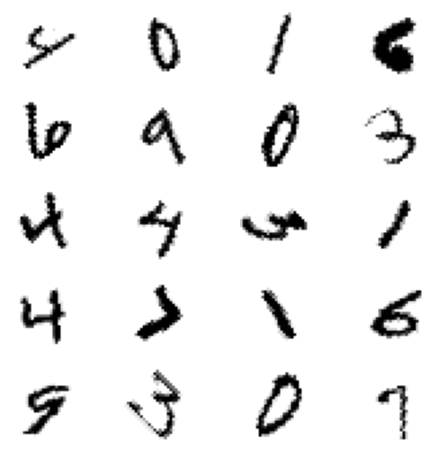

In [82]:
from scipy.ndimage.interpolation import rotate

rng = np.random.RandomState(42)

# transforms image by randomly choosing a set of transform operations and applying to set of images
def img_ortogal_transform(img):
    choiches = ['fliplr', 'flipud', 'rotleft', 'rotright']

    operations = rng.choice(choiches, rng.randint(1, len(choiches)+1), replace=True)

    for operation in operations:
        if operation == 'fliplr':
            img = np.fliplr(img)
        elif operation == 'flipud':
            img = np.flipud(img)
        elif operation == 'rotleft':
            img = np.rot90(img, 1)
        elif operation == 'rotright':
            img = np.rot90(img, 2)

    return img

# transform images by rotation
def img_rot_transfomer(img):
    angle = rng.randint(-45, 45)
    return rotate(img, angle, prefilter=False, reshape=False, order=0)

transform_func = lambda img: img_rot_transfomer(img.reshape(28, 28)).reshape(784)

X_augumented = [transform_func(img) for img in X_train[:50000]]
Y_augumented = Y_train[:50000]

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_augumented[i].reshape(28, 28), cmap='binary')
    plt.axis('off')

plt.show()

In [83]:
X_train_augumented = np.concatenate((X_train, X_augumented), axis=0)
Y_train_augumented = np.concatenate((Y_train, Y_augumented), axis=0)

In [84]:
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')
knn_clf.fit(X_train_augumented, Y_train_augumented)

Y_augumented_pred = knn_clf.predict(X_test)

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

result1 = classification_report(Y_test, Y_augumented_pred)
print(result1)

accuracy = accuracy_score(Y_test, Y_augumented_pred)
print(accuracy)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       983
           1       0.96      0.99      0.98      1152
           2       0.98      0.97      0.97       967
           3       0.97      0.96      0.97      1034
           4       0.97      0.97      0.97       906
           5       0.97      0.97      0.97       937
           6       0.98      0.99      0.98       961
           7       0.96      0.98      0.97      1055
           8       0.99      0.94      0.96       969
           9       0.96      0.96      0.96      1036

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

0.973
